Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
# dataset location - http://insideairbnb.com/get-the-data.html

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

listings = pd.read_csv('listings.csv')

listings.shape

(7435, 16)

In [3]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,4952,Butterfly Inn - Graceful Living !,7054,Mei Lin,NaN,Palo Alto,37.43972,-122.15672,Private room,90,2,75,2019-01-12,0.61,5,52
1,11464,Deluxe Private Studio-custom int.,42458,Emey,NaN,Santa Clara,37.34342,-121.98829,Entire home/apt,85,14,5,2018-08-26,0.08,10,90
2,21373,Bonsai Garden Inn in Professorville,7054,Mei Lin,NaN,Palo Alto,37.44001,-122.15667,Private room,99,2,240,2019-09-15,2.12,5,276
3,23732,Heart of Silicon Valley bdrm & bath,2077,Igor,NaN,Mountain View,37.39203,-122.06675,Private room,299,1,3,2011-07-07,0.03,1,365
4,37154,Private room in a 2 bedroom home in Campbell,160433,Daniel,NaN,San Jose,37.30213,-121.95890,Private room,61,2,36,2019-09-13,2.41,1,26


In [4]:
# Target column is "price" and will need Regression model type

listings['price'].value_counts()



50       195
75       189
100      178
60       168
150      168
        ... 
1100       1
1180       1
282        1
10000      1
16         1
Name: price, Length: 441, dtype: int64

In [6]:
listings['price'].describe()

count     7435.000000
mean       164.619906
std        283.108458
min         10.000000
25%         65.000000
50%        100.000000
75%        185.000000
max      10000.000000
Name: price, dtype: float64

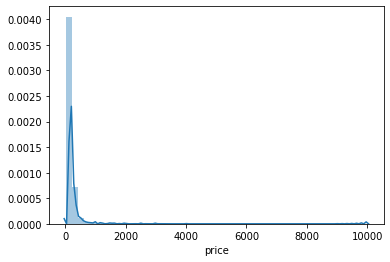

In [7]:
%matplotlib inline
import seaborn as sns
sns.distplot(listings['price']);


In [0]:
# Target appeared right-skewed so need to apply log transformation

import numpy as np
price_log = np.log1p(listings['price'])

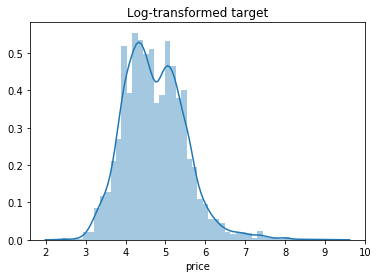

In [17]:
import matplotlib.pyplot as plt

sns.distplot(price_log)
plt.title('Log-transformed target'); # price here is log dollars

In [0]:
#Removing Outliers?

import numpy as np

listings = listings[(listings['price'] >= np.percentile(listings['price'], 0.5)) & 
        (listings['price'] <= np.percentile(listings['price'], 99.5)) & 
        (listings['latitude'] >= np.percentile(listings['latitude'], 0.05)) & 
        (listings['latitude'] < np.percentile(listings['latitude'], 99.95)) &
        (listings['longitude'] >= np.percentile(listings['longitude'], 0.05)) & 
        (listings['longitude'] <= np.percentile(listings['longitude'], 99.95))]

In [18]:
# Feature selection, splitting the data

from sklearn.model_selection import train_test_split

train, test = train_test_split(listings, test_size=0.20, random_state=42 )

train, val = train_test_split(train, test_size=0.20, random_state=42 )

train.shape, test.shape, val.shape

((4704, 16), (1471, 16), (1176, 16))

In [19]:
# The status_group column is the target
target = 'price'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 100].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(len(features))
print(features)

11
['host_id', 'neighbourhood_group', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood', 'room_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_val_score

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    LinearRegression()
)

In [21]:
# Apply logarithmic transformation to data set before fitting the model

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))

82.0520173464766
